
# Team Network demo

The goal of this notebook is to show network concepts that can aid college basketball analysis

- I'll start in the abstract, with simulated scores.
- Then I'll move to actual CBB data



### Introduction

There are around 350 teams in college basketball and there isn't enough time for them to all play each other. Teams instead are arranged in conferences that play each other regularly. Non-conference games offer a glimpse into relative strength between conferences, but they are limited. Therefore, we must infer some team strength from the strength of their opponents and their opponent's opponents. This naturally lends itself to network architecture.

If all teams played in a fully connected network, the network approach would be less useful. I'll demonstrate below.


##### Section 1. Comparing fully connected schedule vs. One with "conference" schedules

Let's first examine our ability to recover a "true rating" when all teams play each other once. For this first experiment, I'll use 18 teams to demonstrate.  

For simplicity, team with a rating "8" will beat a team with rating "0" by 8 points on average. However, there will be
randomness to the results. Home court advantage, overtime, etc. could be added but I decided against to keep things as simple as possible. 

The goal is to recover the "true rating".

In [1]:

import networkx

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from faker import Faker
from itertools import combinations





fake = Faker()

# generate teams
teams = pd.DataFrame([(fake.name(), np.random.normal(0, 8)) for i in range(18)], columns=['name', 'true_rating'])
teams.head()


,name,true_rating
0,Joseph Graves,-8.493232
1,George Shaw,11.101298
2,Michael Jennings,3.690803
3,Eric Williams,1.268077
4,David Delgado,1.663317


In [2]:

# Randomly generate game results with noise centered around true skill

def play_game(skill_1, skill_2, vol=6):
    return np.random.normal(skill_1, vol) - np.random.normal(skill_2, vol)


def play_season(schedule, skill_dict):
    
    game_results = []
    
    for game in schedule:
        
        team_1_true_skill = skill_dict[game[0]]
        team_2_true_skill = skill_dict[game[1]]
        
        game_result = play_game(team_1_true_skill, team_2_true_skill)
        game_results.append([game[0], game[1], game_result])
        game_results.append([game[1], game[0], -1*game_result])
    return pd.DataFrame(game_results, columns=['team_1','team_2','result'])

skill_dict = teams.copy().set_index('name').to_dict()['true_rating']
schedule = list(combinations(list(teams.name.values),2))

game_results = play_season(schedule, skill_dict)
game_results.head()


,team_1,team_2,result
0,Joseph Graves,George Shaw,-18.566265
1,George Shaw,Joseph Graves,18.566265
2,Joseph Graves,Michael Jennings,-10.769048
3,Michael Jennings,Joseph Graves,10.769048
4,Joseph Graves,Eric Williams,-31.001194



One way to recover the "true" rating from the random game results is to one hot encode each team, and then run a ridge regression with the result as the target. The corresponding coefficient will correlate will with the true rating.


In [3]:

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

def return_ratings_xy(rdata):
    
    y = rdata.result.values.reshape(-1,1)
    
    # don't need to shuffle for linear regression
    team_ohe = OneHotEncoder()
    team_X = team_ohe.fit_transform(rdata.team_1.values.reshape(-1,1)).toarray() # need toarray because it doesn't return a numpy object
    opp_ohe = OneHotEncoder()
    opp_X = opp_ohe.fit_transform(rdata.team_2.values.reshape(-1,1)).toarray()
    
    # save team ids for later
    team_order = np.array(team_ohe.categories_[0])
    X = np.concatenate((team_X, opp_X), axis=1)
    
    return X, y, team_order

def get_team_ratings(X, y, teams, ridge_alpha=0.1):
    
    model = Ridge(ridge_alpha)
    model.fit(X,y)
    team_ratings = model.coef_[0][:len(teams)]
    team_ratings = pd.DataFrame.from_dict({
        'name':teams,
        'model_rating':team_ratings
    })
    return team_ratings

X, y, team_order = return_ratings_xy(game_results)
model_ratings = get_team_ratings(X, y, team_order)

model_ratings.head()



,name,model_rating
0,Beverly Waters,-3.865857
1,Brittany Gardner,-2.595798
2,Carly Finley,8.496984
3,David Delgado,-0.713346
4,David Weber,1.680969


In [4]:

# merge in true ratings
results = model_ratings.copy().merge(teams.copy(), how='left')
results.head()


,name,model_rating,true_rating
0,Beverly Waters,-3.865857,-0.866271
1,Brittany Gardner,-2.595798,-1.185376
2,Carly Finley,8.496984,10.907984
3,David Delgado,-0.713346,1.663317
4,David Weber,1.680969,0.351077


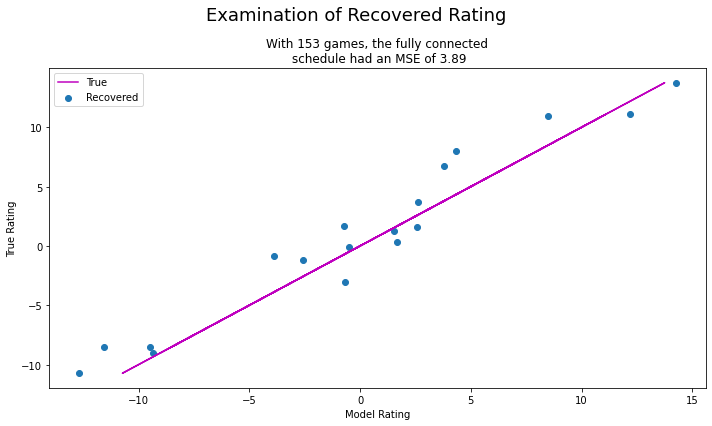

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(results.true_rating, results.true_rating, c='m', label='True')
plt.scatter(results.model_rating, results.true_rating, label='Recovered')

full_connected_error= np.round(np.mean((results['model_rating'].copy() - results['true_rating'].copy())**2),3)
plt.suptitle("Examination of Recovered Rating", fontsize=18)
plt.title(f"With {len(schedule)} games, the fully connected\n schedule had an MSE of {full_connected_error}")
plt.xlabel("Model Rating")
plt.ylabel("True Rating")
plt.legend()
plt.tight_layout()
plt.show()



This is great, but we really need to bootstrap to get a lot of samples for a fair comparison.




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.25it/s]


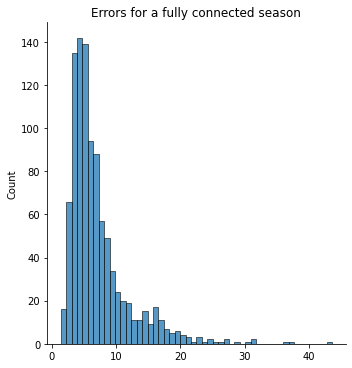

In [6]:

def sim_fc_season():
    
    fake = Faker()
    
    # generate teams
    teams = pd.DataFrame([(fake.name(), np.random.normal(0, 8)) for i in range(18)], columns=['name', 'true_rating'])
    # create schedule
    skill_dict = teams.copy().set_index('name').to_dict()['true_rating']
    schedule = list(combinations(list(teams.name.values),2))
    # run season
    game_results = play_season(schedule, skill_dict)
    # run model
    X, y, team_order = return_ratings_xy(game_results)
    model_ratings = get_team_ratings(X, y, team_order)
    # get error
    results = model_ratings.copy().merge(teams.copy(), how='left')
    return np.mean((results['model_rating'].copy() - results['true_rating'].copy())**2)

fc_errors = []
for i in tqdm(range(1000)):
    fc_error = sim_fc_season()
    fc_errors.append(fc_error)
    
sns.displot(fc_errors)
plt.title("Errors for a fully connected season")
plt.show()


This time, I will do the same amount of games for each team. However, there will be 3 "conferences" of 6 teams each. To demonstrate potential problems with estimating relative conference skill, each team will play 12 conference games and 5 non-conference games.


In [8]:

## cell for creating networkx graphs





153.0

In [ ]:

def sim_conf_season():
    
    fake = Faker()
    
    # generate teams
    teams = pd.DataFrame([(fake.name(), np.random.normal(0, 8)) for i in range(18)], columns=['name', 'true_rating'])
    # create schedule
    skill_dict = teams.copy().set_index('name').to_dict()['true_rating']
    schedule = list(combinations(list(teams.name.values),2))
    # run season
    game_results = play_season(schedule, skill_dict)
    # run model
    X, y, team_order = return_ratings_xy(game_results)
    model_ratings = get_team_ratings(X, y, team_order)
    # get error
    results = model_ratings.copy().merge(teams.copy(), how='left')
    return np.mean((results['model_rating'].copy() - results['true_rating'].copy())**2)

conf_errors = []
for i in tqdm(range(1000)):
    conf_error = sim_conf_season()
    conf_errors.append(conf_error)


